# Tutorial Example
Go through synthesizAR example step-by-step from the beginning. Ideally this will end up in a tutorial in the docs.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from sunpy.sun import constants
from sunpy.map import Map
from sunpy.net import Fido,attrs as a,vso
from sunpy.time import TimeRange

import synthesizAR
import synthesizAR.extrapolate
from synthesizAR.util import heeq_to_hcc_coord

%matplotlib inline

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Download Magnetogram Data

First, construct a query for an HMI magnetogram.

In [5]:
q = Fido.search(
    a.Time(TimeRange('2013/01/01 00:03:30', '2013/01/01 00:04:30')),
    a.Instrument('HMI'), vso.attrs.Physobs('LOS_magnetic_field')
)

In [6]:
q

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2013-01-01 00:04:09,2013-01-01 00:04:10,SDO,HMI,FULLDISK,6173.0 .. 6174.0


In [7]:
res = Fido.fetch(q)

[                                        ========================================


In [3]:
magnetogram = Map('/Users/willbarnes/sunpy/data/hmi_m_45s_2013_01_01_00_05_15_tai_magnetogram.fits')#res)

## Prep Magnetogram

Magnetograms are delivered by the VSO rotated by 180$^{\circ}$. We'll rotate it back to make the orientation sensible.

In [3]:
magnetogram = magnetogram.rotate(order=3)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


In [1]:
plt.figure(figsize=(10,10))
magnetogram.plot(vmin=-1.5e3,vmax=1.5e3,cmap='hmimag')

NameError: name 'plt' is not defined

We need to crop to the region of interest which in this case is AR NOAA 11640. We can crop the map by defining a left and right corner.

In [61]:
blc = SkyCoord(-250*u.arcsec, 350*u.arcsec, frame=magnetogram.coordinate_frame)
trc = SkyCoord(75*u.arcsec, 650*u.arcsec, frame=magnetogram.coordinate_frame)

In [62]:
magnetogram_ar = magnetogram.submap(blc,trc)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


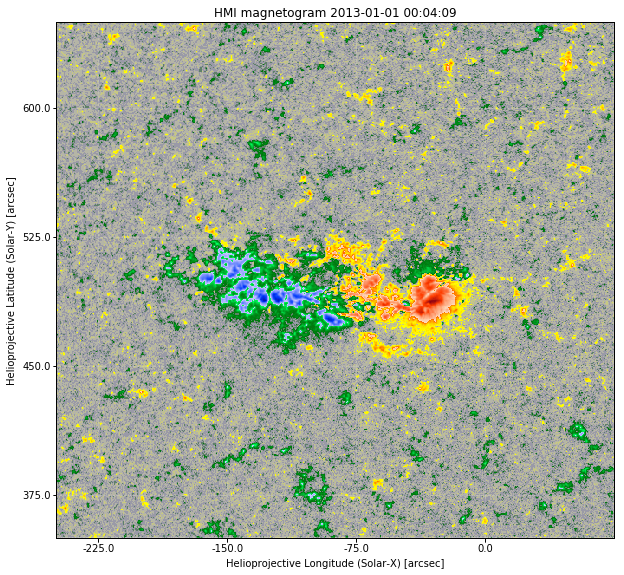

In [63]:
plt.figure(figsize=(10,10))
magnetogram_ar.plot(vmin=-1.5e3,vmax=1.5e3,cmap='hmimag')

Finally, we need to resample the field in order to compute the field extrapolation in a reasonable amount of time.

In [64]:
magnetogram_ar_resampled = magnetogram_ar.resample([100,100]*u.pixel)

## Extrapolate Field and Trace Fieldlines

Next, we want to use this magnetogram to compute an extrapolated magnetic field. This can be done using a package like pfss in SSWIDL or a non-linear force-free extrapolation. We will use the potential field extrapolation method included in this package.

In [65]:
width_z = 0.3 * const.R_sun
shape_z = 100*u.pixel

In [66]:
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram_ar_resampled, width_z, shape_z)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


In [67]:
B_field = extrapolator.extrapolate()

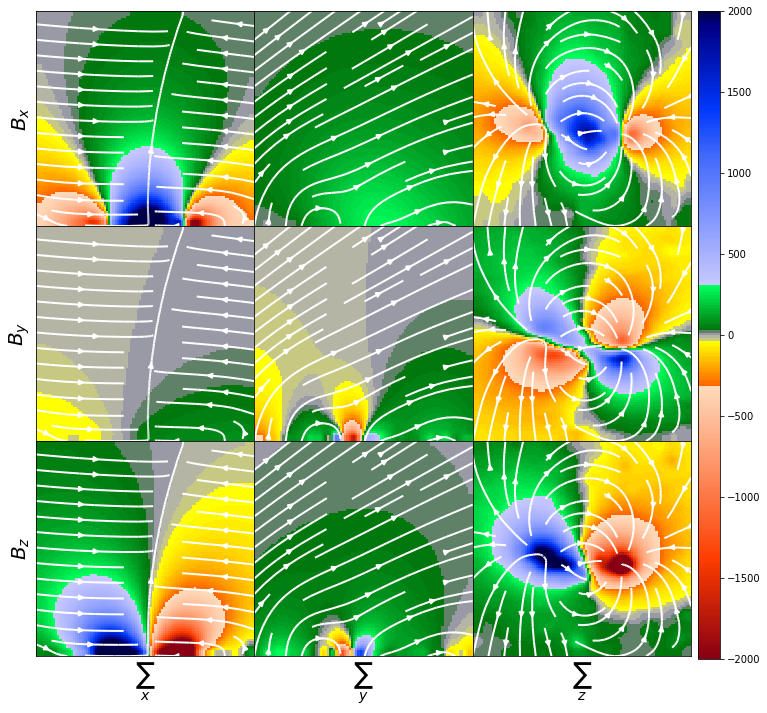

In [68]:
synthesizAR.extrapolate.peek_projections(B_field)

To get the "loops" out of our extrapolated field, we'll trace fieldlines through the extrapolated volume.

In [69]:
fieldlines_pos = extrapolator.trace_fieldlines(B_field, 250, loop_length_range=[5,100]*u.Mm,
                                           close_threshold=0.05, mask_threshold=0.25,direction=1)

yt : [INFO     ] 2018-05-11 01:45:41,757 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-11 01:45:41,758 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-05-11 01:45:41,761 Parameters: domain_left_edge          = [-1.12258951e+10 -1.12456711e+10  0.00000000e+00]
yt : [INFO     ] 2018-05-11 01:45:41,764 Parameters: domain_right_edge         = [1.07643021e+10 1.36861395e+10 2.08710000e+10]
yt : [INFO     ] 2018-05-11 01:45:41,766 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-05-11 01:45:42,307 AMRKDTree rebuilt, Final Volume: 1.144264e+31
Streamlining: 100%|██████████| 250/250 [00:00<00:00, 405.23it/s]
yt : [INFO     ] 2018-05-11 01:45:43,384 AMRKDTree rebuilt, Final Volume: 1.144264e+31
Streamlining: 100%|██████████| 86/86 [00:00<00:00, 413.65it/s]
yt : [INFO     ] 2018-05-11 01:45:43,900 AMRKDTree rebuilt, Final Volume: 1.144264e+31
Streamlining: 100%|██████████| 35/35 [00:00<00:00, 352.17it/s]
yt : [INFO     ] 2018-05

FloatProgress(value=0.0)

In [70]:
fieldlines_neg = extrapolator.trace_fieldlines(B_field, 250, loop_length_range=[5,100]*u.Mm,
                                           close_threshold=0.05, mask_threshold=-0.25,direction=-1)

yt : [INFO     ] 2018-05-11 01:45:59,880 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-11 01:45:59,881 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-05-11 01:45:59,881 Parameters: domain_left_edge          = [-1.12258951e+10 -1.12456711e+10  0.00000000e+00]
yt : [INFO     ] 2018-05-11 01:45:59,882 Parameters: domain_right_edge         = [1.07643021e+10 1.36861395e+10 2.08710000e+10]
yt : [INFO     ] 2018-05-11 01:45:59,883 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-05-11 01:46:00,424 AMRKDTree rebuilt, Final Volume: 1.144264e+31
Streamlining: 100%|██████████| 250/250 [00:00<00:00, 595.55it/s]
yt : [INFO     ] 2018-05-11 01:46:01,363 AMRKDTree rebuilt, Final Volume: 1.144264e+31
Streamlining: 100%|██████████| 69/69 [00:00<00:00, 543.38it/s]
yt : [INFO     ] 2018-05-11 01:46:01,810 AMRKDTree rebuilt, Final Volume: 1.144264e+31
Streamlining: 100%|██████████| 21/21 [00:00<00:00, 471.27it/s]
yt : [INFO     ] 2018-05

FloatProgress(value=0.0)

In [72]:
fieldlines = fieldlines_neg + fieldlines_pos

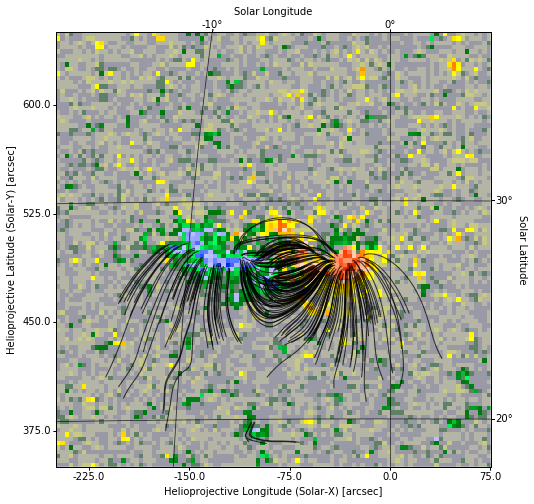

In [73]:
extrapolator.peek(fieldlines, line_frequency=2, alpha=0.75)

In [74]:
fieldlines_filtered = []
for f in fieldlines:
    l_coord = heeq_to_hcc_coord(f[0][:,0],f[0][:,1],f[0][:,2],magnetogram_ar_resampled.observer_coordinate).transform_to(
        magnetogram_ar_resampled.coordinate_frame)
    if np.any(np.logical_or(l_coord.Tx < -150*u.arcsec, l_coord.Tx > -30*u.arcsec)):
        continue
    fieldlines_filtered.append(f)

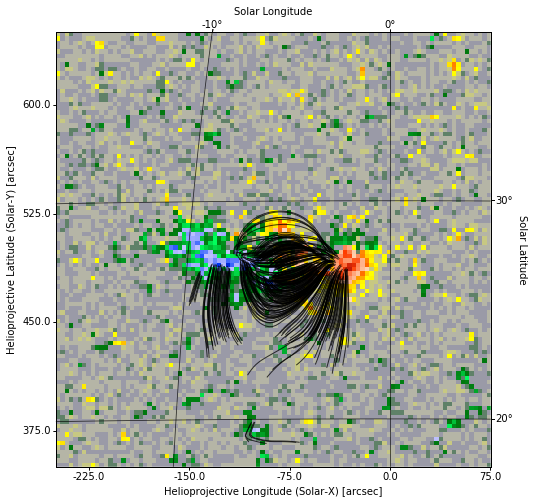

In [75]:
extrapolator.peek(fieldlines_filtered,line_frequency=1,alpha=0.75)

## Create Active Region

## Run Hydrodynamic Simulation

### Setup A Heating Model

We'll configure a heating model where each strand is heated exactly once and at a randomly chosen time during the simulation period.

In [ ]:
class OutofPhaseNanoflares(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        
    def calculate_event_properties(self,loop):
        self.number_events = 1
        start_time = np.random.uniform(low=0, high=self.base_config['total_time'] - self.heating_options['duration'])
        max_energy = (self.heating_options['stress_level'] * loop.field_strength.mean().value)**2/(8.*np.pi)
        return {'magnitude': np.array([max_energy/(self.heating_options['duration']/2.)]),
                'rise_start': np.array([start_time]),
                'rise_end': np.array([start_time+self.heating_options['duration']/2]),
                'decay_start': np.array([start_time+self.heating_options['duration']/2]),
                'decay_end': np.array([start_time+self.heating_options['duration']])}

In [ ]:
heating_options = {
    'duration':200.0,
    'stress_level':0.3,
}
heating_model = OutofPhaseNanoflares(heating_options)

### Configure and Run Simulation

In [ ]:
ih = synthesizAR.util.InputHandler(
    '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [ ]:
ebtel_interface = EbtelInterface(
    base_config,heating_model,
    'tutorial_example/hydro_config/',
    'tutorial_example/hydro_results/')

In [ ]:
field.configure_loop_simulations(ebtel_interface,)

In [ ]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/Users/willbarnes/Documents/work/codes/',
                                  'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
field.load_loop_simulations(
    ebtel_interface,
    'tutorial_example/loop_parameters.h5')

Plot the output of all of our loop simulations

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::5]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.1)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.1)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.05)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')